# Computing Private Load Shapes #

In example notebooks up to here, we have laid the groundwork for computing private load shapes.

In [Computing Bounds for Clamped Means](clamped-mean-bounds.ipynb), we determined the clamping parameters for a dataset of unknown range.

In [Private Load Shape Algorithm Design](private-load-shape-algorithm-design.ipynb), we determined that the Gaussian Mechanism was best suited for load shape queries.

Here, we will perform the query against a synthetic dataset to tie all the work together.

In [1]:
# Preamble: imports and figure settings

from eeprivacy import (
  PrivateVectorClampedMean,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from scipy import stats

np.random.seed(1234) # Fix seed for deterministic documentation

mpl.style.use("seaborn-white")

MD = 28
LG = 36
plt.rcParams.update({
    "figure.figsize": [25, 18],
    "legend.fontsize": MD,
    "axes.labelsize": LG,
    "axes.titlesize": LG,
    "xtick.labelsize": LG,
    "ytick.labelsize": LG,
})

## Dataset ##

For this example, we generate a population of synthetic daily load shapes:

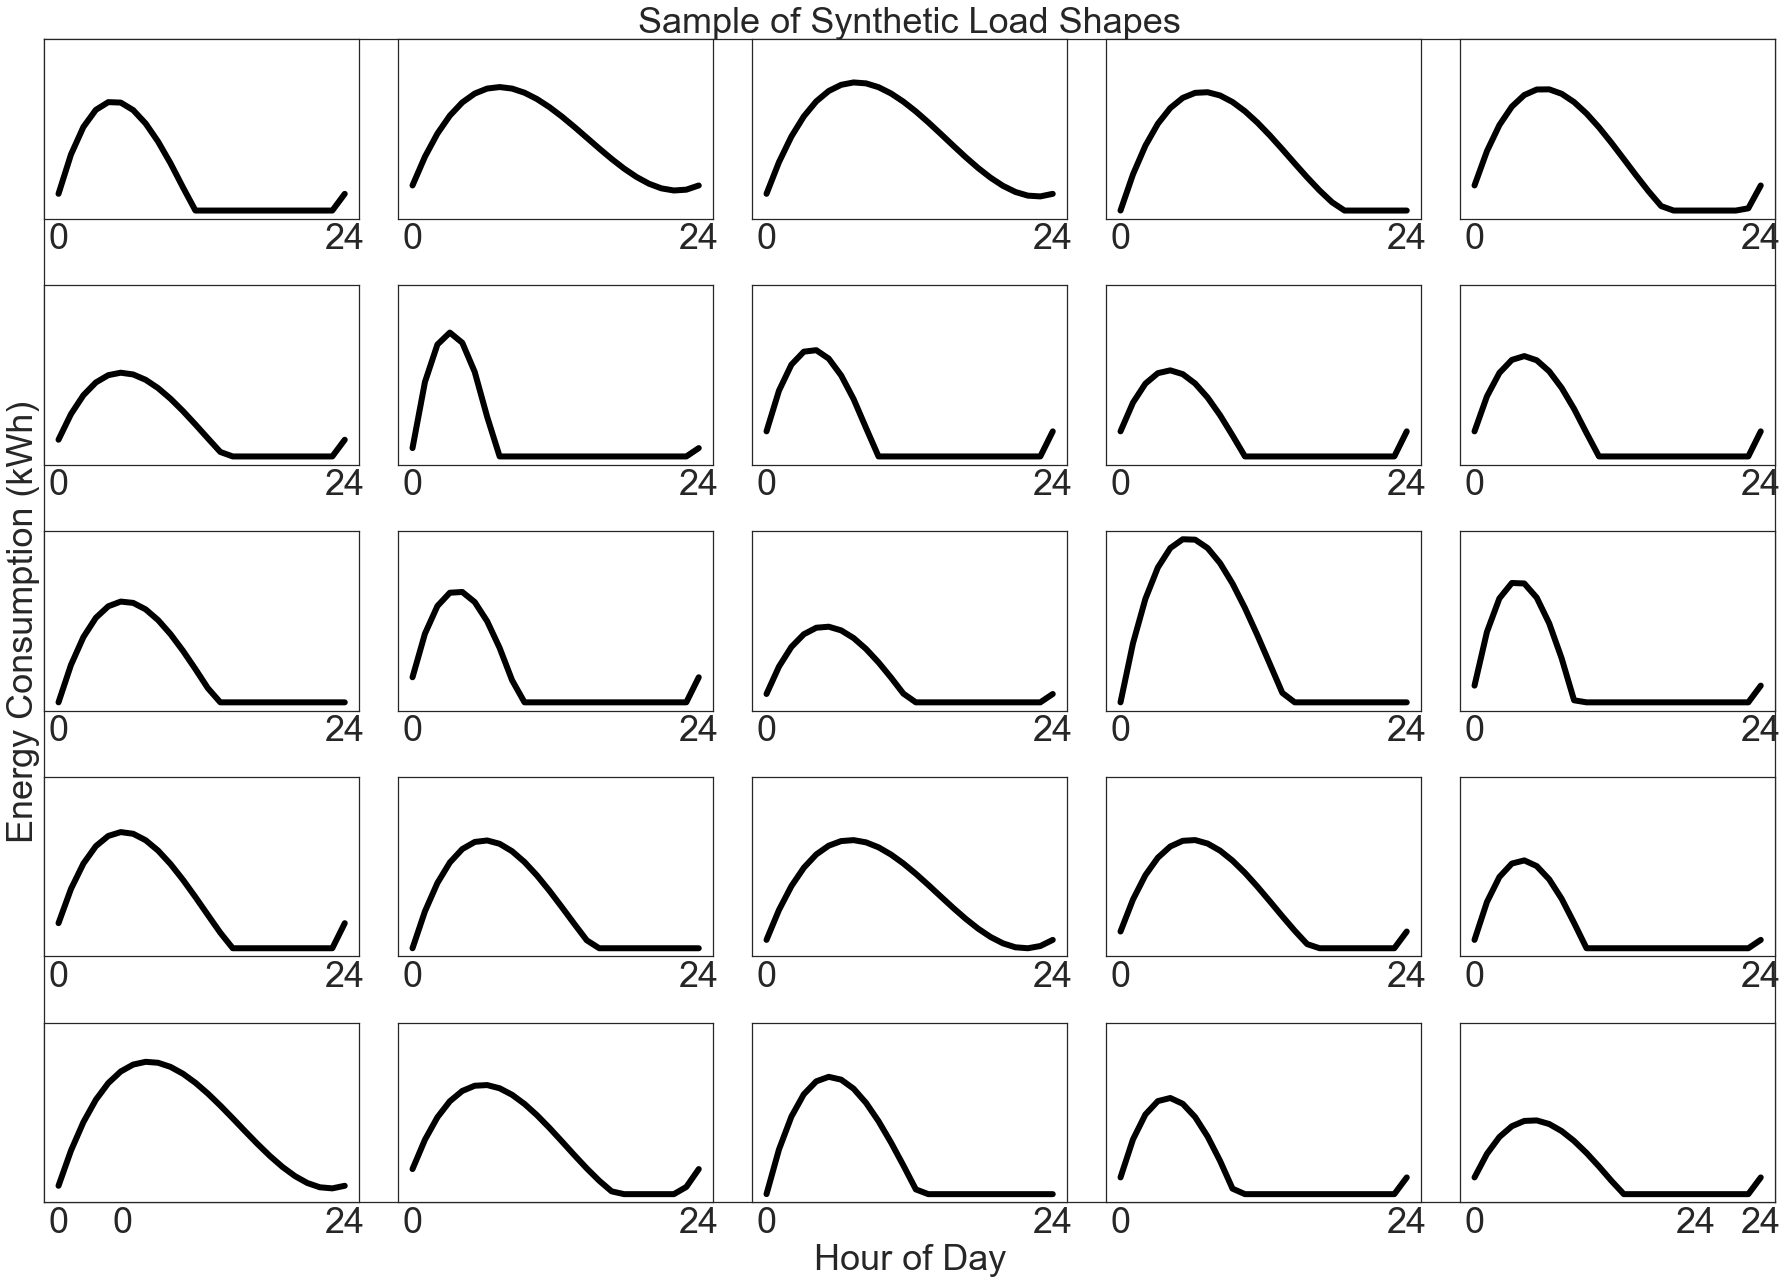

In [2]:
def synthetic_load_shape():
    x = np.array([
      0, 
      np.random.randint(2, 6), 
      np.random.randint(7, 18), 
      24
    ])
    y0 = np.random.randint(low=0, high=4)
    y = np.array([
      y0, 
      np.random.randint(low=8, high=14), 
      np.random.randint(low=0, high=9), 
      y0
    ])
    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    xs = np.linspace(0, 24, num=24)
    ys = p(xs)
    ys[ys < 0] = 0
    return ys
 
xs = np.linspace(0, 24, num=24)

R = 5
C = 5

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(R):
    for k in range(C):
        axx = fig.add_subplot(R, C, i*C+k+1, sharex=ax, sharey=ax)
        axx.set_xticks([0, 24])
        axx.set_yticks([])
        axx.plot(xs, synthetic_load_shape(), linewidth=6, color="k")

fig.tight_layout(pad=3.0)
        
ax.set_title("Sample of Synthetic Load Shapes")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Energy Consumption (kWh)")
plt.show()

## Applying Gaussian Mechanism for Load Shapes ##

We would like to find the average load shape for the entire population.

We use the vector form of the Gaussian Mechanism to find the average load shape. We also plot error bars resulting from differential privacy.

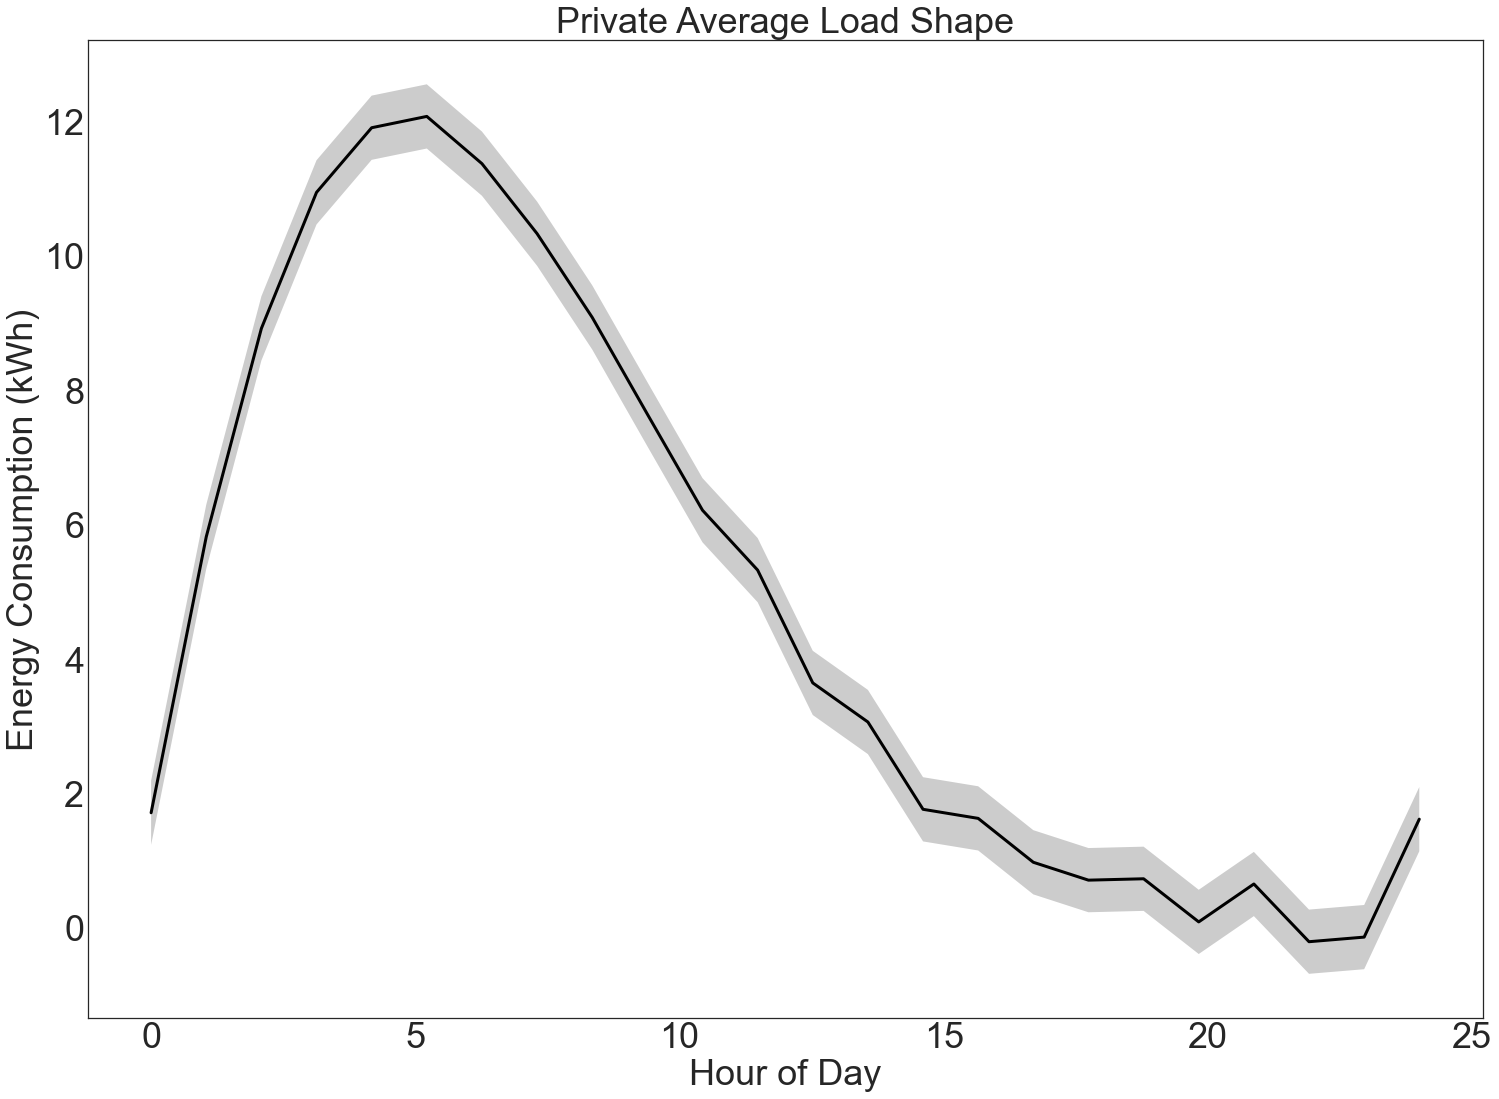

In [4]:
N = 3000

load_shapes = np.array([synthetic_load_shape()])
xs = np.linspace(0, 24, num=24)
for i in range(N-1):
  load_shapes = np.concatenate((load_shapes, np.array([synthetic_load_shape()])), axis=0)

true_average_load_shape = np.mean(load_shapes, axis=0)

# Here we assume the count is not private, using a private sum
# and an exact count to get the average load shape.

private_mean_op = PrivateVectorClampedMean(
  lower_bound=0,
  upper_bound=20,
  k=24,
  N=N
)

private_average_load_shape = private_mean_op.execute(
  vectors=load_shapes,
  epsilon=1.0,
  delta=1e-12
)

ci = private_mean_op.confidence_interval(
  epsilon=1.0,
  delta=1e-12,
  confidence=0.95
)

plt.plot(xs, private_average_load_shape, linewidth=3, color="k")

plt.fill_between(xs, private_average_load_shape - ci, private_average_load_shape + ci, facecolor="k", alpha=0.2)
    
plt.title("Private Average Load Shape")
plt.xlabel("Hour of Day")
plt.ylabel("Energy Consumption (kWh)")
plt.show()